# Compute seasonal net outgassing of O2 and APO

Start with [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like [util.py](util.py).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import util

import intake

## Connect to catalog

This notebook uses an [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) to describe file locations. This is the basis of [intake-esm](https://intake-esm.readthedocs.io/en/latest/), though here we are not using `intake-esm` directly.

In [3]:
cat = intake.open_esm_datastore(util.catalog_json)
cat

,unique
activity_id,17
institution_id,34
source_id,74
experiment_id,127
member_id,399
table_id,35
variable_id,1064
grid_label,12
dcpp_init_year,59
version,500


In [4]:
%%time
df = pd.read_csv(util.catalog_csv)
df

CPU times: user 5 s, sys: 303 ms, total: 5.3 s
Wall time: 5.3 s


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
1,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
2,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
3,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
4,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r3i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
...,...,...,...,...,...,...,...,...,...,...,...,...
1850252,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,6hrLev,va,gn,NaN,v20200602,209901010600-210001010000,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850253,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,6hrLev,va,gn,NaN,v20200602,210001010600-210101010000,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850254,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Oday,tos,gn,NaN,v20190726,20150101-20491230,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850255,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Oday,tos,gn,NaN,v20190726,20500101-20991230,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...


## Specify a subset of models

In [5]:
models = [
    'CanESM5', ## gives non-monotonic coord error for fgco2 in combine_by_coords below 
    #'CanESM5-CanOE', ## no fgo2 (somehow PM was plotting)
    'CNRM-ESM2-1', 
    'ACCESS-ESM1-5', # missing sos 
    'MPI-ESM-1-2-HAM',  # missing sos
    'IPSL-CM6A-LR',
    'MPI-M.MPI-ESM1-2-HR', 
    'MPI-ESM1-2-LR',  # missing sos
    'NorCPM1', 
    'NorESM2-LM', 
    'UKESM1-0-LL',
    'MIROC-ES2L', # missing hfds
    'MRI-ESM2-0', # missing intpp, sos
]
## others on ESGF showing historical+Omon+fgo2 = EC-Earth3-CC, GFDL-CM4, GFDL-ESM4, IPSL-CM5A2-INCA, IPSL-CM6A-LR-INCA, NorESM2-MM (but of the above ESGF not showing CNRM-ESM2-1, UKESM1-0-LL, MIROC-ES2L, MRI-ESM2-0)


### Test read single model

In [6]:
source_id = 'UKESM1-0-LL'
variable_id = ['sos']
time_slice = slice('2005', '2014')
experiment_id = 'historical' 
nmax_members = 4

dsi = util.open_cmip_dataset(
    source_id=source_id, 
    variable_id=variable_id, 
    experiment_id=experiment_id, 
    time_slice=time_slice, 
    table_id='Omon',
    nmax_members=nmax_members,
)
dsi

UKESM1-0-LL, historical, ['sos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 6 ensemble members


<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 330, member_id: 4, time: 120, vertices: 4)
Coordinates:
  * time                (time) object 2005-01-16 00:00:00 ... 2014-12-16 00:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * member_id           (member_id) <U8 'r1i1p1f2' 'r2i1p1f2' ... 'r4i1p1f2'
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    sos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
Attributes: (12/43)
    license:                 CMIP6 model data produced by the Met Office Hadl...
    parent_variant_label:    r1i1p1f2
    institution_id:          MOHC
    product:                 model-output
    tracking_id:             hdl:21.14100/441ff34c-3547-49a1-b3e7-67478ae3337...
    Conventions:             CF-1.7 CMIP-6.2
    ...                      ...
    branch_time_in_child:    0.0
    variable_id:             sos
    data_specs_version:      01.00.29
    cv_version:              6.2.20.1
    table_info:              Creation Date:(13 December 2018) MD5:2b12b5db6db...
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn

### Test calculating derived variables

In [7]:
source_id = 'UKESM1-0-LL'
#variable_name = 'fgn2:sos,tos,hfds'
variable_name = 'fgo2_thermal:sos,tos,hfds'
time_slice = slice('2005', '2014')
experiment_id = 'historical' 
nmax_members = 4

print(variable_name)
variable_id = variable_name
derived_var = variable_name
if ':' in variable_id:
    variable_id = variable_name.split(':')[-1].split(',')
    derived_var = variable_name.split(':')[0]        
    print(variable_id)
    print(derived_var)
                
dsi = util.open_cmip_dataset(
    source_id=source_id, 
    variable_id=variable_id, 
    experiment_id=experiment_id, 
    time_slice=time_slice, 
    table_id='Omon',
    nmax_members=nmax_members,
)

# compute derived variables
if derived_var == 'fgn2':
    dsi = util.compute_fgn2(dsi)

elif derived_var == 'fgo2_thermal':
    dsi = util.compute_fgo2_thermal(dsi)

dsi

fgo2_thermal:sos,tos,hfds
['sos', 'tos', 'hfds']
fgo2_thermal
UKESM1-0-LL, historical, ['sos', 'tos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 16 ensemble members


<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 330, member_id: 4, time: 120, vertices: 4)
Coordinates:
  * member_id           (member_id) <U9 'r1i1p1f2' 'r2i1p1f2' ... 'r4i1p1f2'
  * time                (time) object 2005-01-16 00:00:00 ... 2014-12-16 00:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    hfds                (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    sos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    tos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    fgo2_thermal        (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
Attributes: (12/43)
    license:                 CMIP6 model data produced by the Met Office Hadl...
    parent_variant_label:    r1i1p1f2
    institution_id:          MOHC
    product:                 model-output
    tracking_id:             hdl:21.14100/7b01733f-fd0f-4adb-8d8b-35d642e8721...
    Conventions:             CF-1.7 CMIP-6.2
    ...                      ...
    branch_time_in_child:    0.0
    variable_id:             tos
    data_specs_version:      01.00.29
    cv_version:              6.2.20.1
    table_info:              Creation Date:(13 December 2018) MD5:2b12b5db6db...
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn

## Get grid data from each model

Skip models where the grid data is not available

In [8]:
dsets_fix = {}
grid_variables = ['areacello',]
for model in models:
    dsets_m = [util.get_gridvar(df, model, v) for v in grid_variables]
    dsets_m = [ds for ds in dsets_m if ds is not None]
    if dsets_m:
        dsets_fix[model] = xr.merge(dsets_m)
        dsets_fix[model].attrs['source_id'] = model
        
list(dsets_fix.keys())
## somehow PM was getting areacello for MPI-M.MPI-ESM1-2-HR from Ofx - I tried specifying table_id as Ofx here but that did not help

MPI-M.MPI-ESM1-2-HR: missing "areacello"
NorCPM1: missing "areacello"


['CanESM5',
 'CNRM-ESM2-1',
 'ACCESS-ESM1-5',
 'MPI-ESM-1-2-HAM',
 'IPSL-CM6A-LR',
 'MPI-ESM1-2-LR',
 'NorESM2-LM',
 'UKESM1-0-LL',
 'MIROC-ES2L',
 'MRI-ESM2-0']

## Compute a region mask for integration

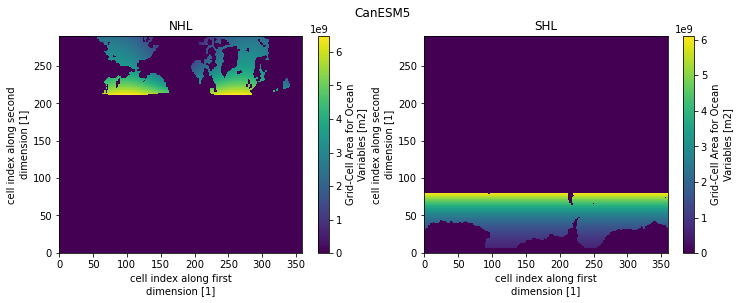

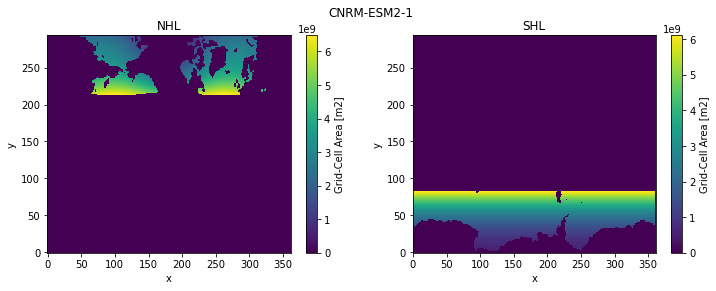

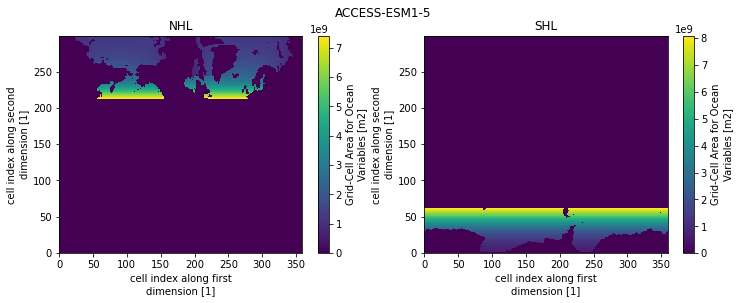

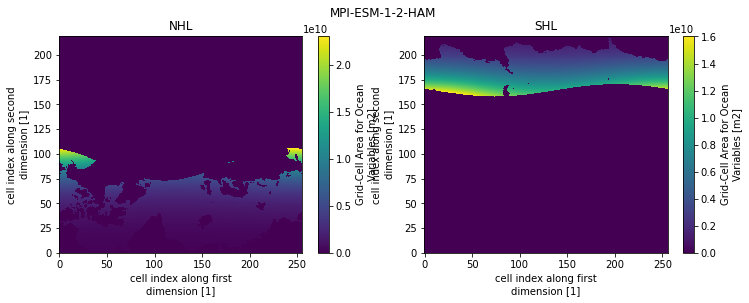

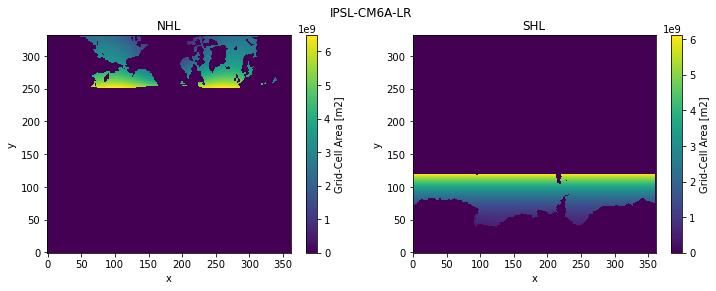

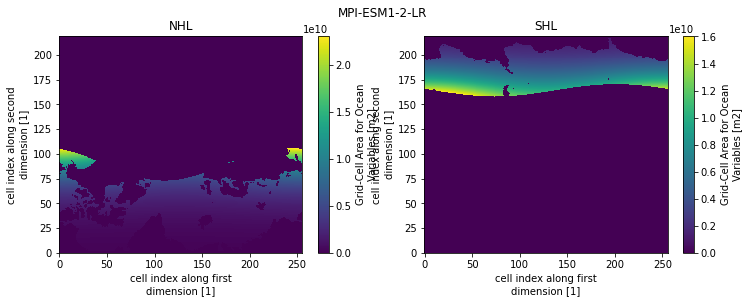

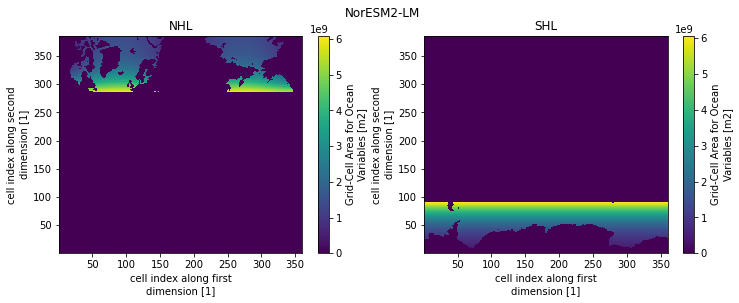

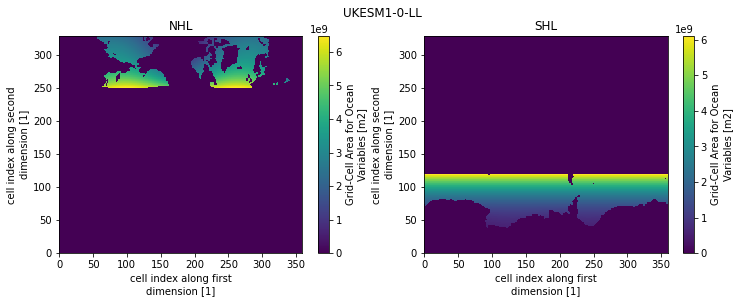

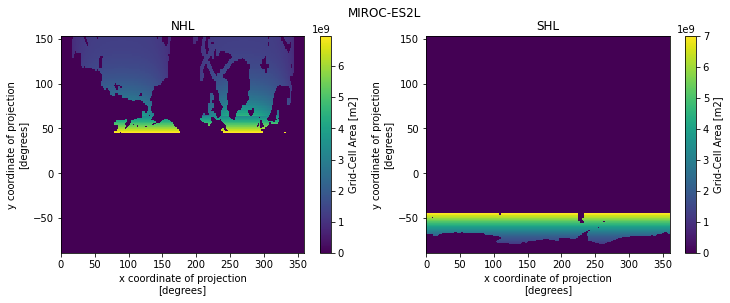

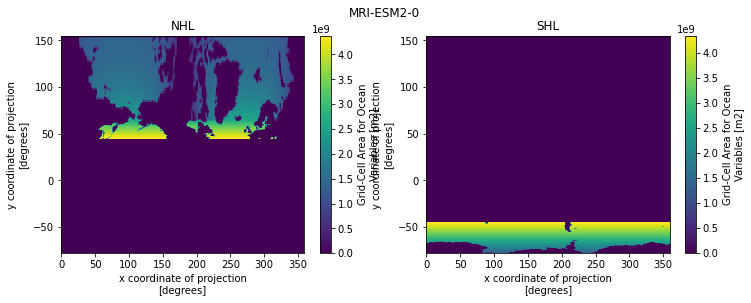

In [16]:
rmask_definition = 'SHL_NHL'
#rmask_definition = 'global' ### grid-cell area is maxing at 20 degrees in each hemisphere

rmask_dict = {}
for model in models:    
    if model not in dsets_fix:
        continue
    rmask_dict[model] = util.get_rmask_dict(
        dsets_fix[model], 
        mask_definition=rmask_definition, 
        plot=True
    )    

## Assemble monthly-mean climatology

This code takes the following steps:
- Read a dataset for each model
- Compute the regional integral 
- Compute the mean for each month and average across ensemble members
- Concatenate the resulting timeseries along a `source_id` dimension

Note that the code is set up to cache the resulting dataset; it will optionally read this dataset, rather than recreate it, if it exists.

In [12]:
missing_search(variable_id='sos') ## have to run following box first to define missing_search


True

In [17]:
%%time
variable_ids = [
    'intpp', 
    'fgco2', 
    'fgo2', 
    'tos', 
    'sos',
    'hfds',
    'fgn2:tos,sos,hfds',
    'fgo2_thermal:tos,sos,hfds',
]
clobber = False
    
time_slice = slice('2005', '2014') ## for comparison to HIPPO/ORCAS/ATom 2009-2018, pick closest decade
experiment_id = 'historical' 
table_id = 'Omon'
nmax_members = 4

# specify models for each variable that have reverse sign convention
models_flipsign = {v.split(':')[0]: [] for v in variable_ids}
models_flipsign['fgo2'] = ['NorESM2-LM',]

missing_data = util.missing_data_tracker()
if clobber:
    missing_data.clobber()


ds_list = []
source_id_list = []
for source_id in models:    
    if source_id not in rmask_dict:
        continue
        
    ds_list_variable_ids = []
    for variable_name in variable_ids:
        
        if ':' in variable_name:
            search_vars = variable_name.split(':')[-1].split(',')
            variable_id = variable_name.split(':')[0]        
        else:
            search_vars = [variable_name]
            variable_id = variable_name
        
        cache_file = (
            f'data/cmip6'
            f'.{source_id}'
            f'.{experiment_id}'
            f'.{variable_id}'
            f'.{rmask_definition}'
            f'.monclim_{time_slice.start}-{time_slice.stop}.zarr'
        )
        if os.path.exists(cache_file) and not clobber:
            ds = xr.open_zarr(cache_file)

        else:
            # see if this is missing
            missing_search = missing_data.ismissing(
                source_id=source_id, 
                experiment_id=experiment_id, 
                table_id=table_id,
            )

            if any(missing_search(variable_id=v) for v in search_vars):
                dsi = None
            else:
                dsi = util.open_cmip_dataset(
                    source_id=source_id, 
                    variable_id=search_vars, 
                    experiment_id=experiment_id, 
                    table_id=table_id,
                    time_slice=time_slice, 
                    nmax_members=nmax_members,
                )
            
                # check to ensure all variables are present
                if dsi is None or not all(v in dsi for v in search_vars):
                    print(f'missing data: {source_id}, {experiment_id}')                
                    for v in search_vars:
                        if dsi is None or v not in dsi:
                            print(f'\t{v}')
                            missing_data.set_missing(
                                source_id=source_id, 
                                variable_id=v, 
                                experiment_id=experiment_id, 
                                table_id=table_id,
                            )
                    dsi = None
                
            if dsi is None:
                # generate missing values dataset
                ds = xr.Dataset({
                    variable_id: xr.DataArray(
                        np.ones((len(rmask_dict[source_id]), 12)) * np.nan,
                        dims=('region', 'month'),
                        name=variable_id,
                    )
                })
                
            else:
                # compute derived variables
                if variable_id == 'fgn2':
                    dsi = util.compute_fgn2(dsi)

                elif variable_id == 'fgo2_thermal':
                    dsi = util.compute_fgo2_thermal(dsi)              

                # compute the regional integrals
                flipsign = True if source_id in models_flipsign[variable_id] else False            
                da = util.compute_regional_integral(
                    ds=dsi, 
                    variable_id=variable_id,
                    rmasks=rmask_dict[source_id],
                    flipsign=flipsign,
                )    

                with xr.set_options(keep_attrs=True):
                    da = da.groupby('time.month').mean().mean('member_id')

                if 'depth' in da.coords:
                    da = da.drop(['depth'])
                
                ds = da.to_dataset().compute()              

                ds.to_zarr(cache_file, mode='w');            
            
        ds_list_variable_ids.append(ds)
    
    if ds_list_variable_ids:
        source_id_list.append(source_id)

    # merge across variables
    if ds_list_variable_ids:
        ds_list.append(xr.merge(ds_list_variable_ids,))

missing_data.persist()        
        
print('final merge')
ds = xr.concat(ds_list, dim=xr.DataArray(source_id_list, dims=('source_id'), name='source_id'))    
ds

CanESM5, historical, ['intpp']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 4 ensemble members
CanESM5, historical, ['fgco2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 50 ensemble members
CanESM5, historical, ['fgo2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 50 ensemble members
CanESM5, historical, ['tos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 50 ensemble members
CanESM5, historical, ['sos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 44 ensemble members
CanESM5, historical, ['hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 41 ensemble members
CanESM5, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 50 ensemble members
CanESM5, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 50 ensemble members
CNRM-ESM2-1, historical, ['intpp']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 10 ensemble members
CNRM-ESM2-1, historical, ['fgco2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 10 ensemble members
CNRM-ESM2-1, historical, ['fgo2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 10 ensemble members
CNRM-ESM2-1, historical, ['tos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 10 ensemble members
CNRM-ESM2-1, historical, ['sos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 5 ensemble members
CNRM-ESM2-1, historical, ['hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 5 ensemble members
CNRM-ESM2-1, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 10 ensemble members
CNRM-ESM2-1, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 10 ensemble members
ACCESS-ESM1-5, historical, ['intpp']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
ACCESS-ESM1-5, historical, ['fgco2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
ACCESS-ESM1-5, historical, ['fgo2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
ACCESS-ESM1-5, historical, ['tos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
MPI-ESM-1-2-HAM, historical, ['intpp']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 2 ensemble members
MPI-ESM-1-2-HAM, historical, ['fgco2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 2 ensemble members
MPI-ESM-1-2-HAM, historical, ['fgo2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 2 ensemble members
MPI-ESM-1-2-HAM, historical, ['tos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 2 ensemble members
IPSL-CM6A-LR, historical, ['intpp']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 32 ensemble members
IPSL-CM6A-LR, historical, ['fgco2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 32 ensemble members
IPSL-CM6A-LR, historical, ['fgo2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 32 ensemble members
IPSL-CM6A-LR, historical, ['tos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 32 ensemble members
IPSL-CM6A-LR, historical, ['sos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 32 ensemble members
IPSL-CM6A-LR, historical, ['hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 31 ensemble members
IPSL-CM6A-LR, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 32 ensemble members
IPSL-CM6A-LR, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 32 ensemble members
MPI-ESM1-2-LR, historical, ['intpp']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 10 ensemble members
MPI-ESM1-2-LR, historical, ['fgco2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 9 ensemble members
MPI-ESM1-2-LR, historical, ['fgo2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 10 ensemble members
MPI-ESM1-2-LR, historical, ['tos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 10 ensemble members
NorESM2-LM, historical, ['intpp']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
NorESM2-LM, historical, ['fgco2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
NorESM2-LM, historical, ['fgo2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
NorESM2-LM, historical, ['tos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
NorESM2-LM, historical, ['sos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 1 ensemble members
NorESM2-LM, historical, ['hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
NorESM2-LM, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
NorESM2-LM, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
UKESM1-0-LL, historical, ['intpp']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 15 ensemble members
UKESM1-0-LL, historical, ['fgco2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 13 ensemble members
UKESM1-0-LL, historical, ['fgo2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 15 ensemble members
UKESM1-0-LL, historical, ['tos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 16 ensemble members
UKESM1-0-LL, historical, ['sos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 6 ensemble members
UKESM1-0-LL, historical, ['hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 8 ensemble members
UKESM1-0-LL, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 16 ensemble members
UKESM1-0-LL, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 16 ensemble members
MIROC-ES2L, historical, ['intpp']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
MIROC-ES2L, historical, ['fgco2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
MIROC-ES2L, historical, ['fgo2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
MIROC-ES2L, historical, ['tos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
MIROC-ES2L, historical, ['sos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 2 ensemble members
MRI-ESM2-0, historical, ['fgco2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 1 ensemble members
MRI-ESM2-0, historical, ['fgo2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 1 ensemble members
MRI-ESM2-0, historical, ['tos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 6 ensemble members
final merge
CPU times: user 20min 53s, sys: 6min 38s, total: 27min 32s
Wall time: 32min 22s


<xarray.Dataset>
Dimensions:       (month: 12, region: 2, source_id: 10)
Coordinates:
  * region        (region) <U3 'NHL' 'SHL'
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * source_id     (source_id) <U15 'CanESM5' 'CNRM-ESM2-1' ... 'MRI-ESM2-0'
Data variables:
    intpp         (source_id, region, month) float64 4.638 7.019 ... nan nan
    fgco2         (source_id, region, month) float32 -8.358 -8.112 ... 0.8759
    fgo2          (source_id, region, month) float32 -20.98 -19.39 ... 34.96
    tos           (source_id, region, month) float32 2.524 2.142 ... 2.471 3.474
    sos           (source_id, region, month) float64 31.72 31.82 ... nan nan
    hfds          (source_id, region, month) float64 -3.884 -3.025 ... nan nan
    fgn2          (source_id, region, month) float64 -32.71 -25.7 ... nan nan
    fgo2_thermal  (source_id, region, month) float64 -19.75 -15.53 ... nan nan

## Make some plots

In [18]:
monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

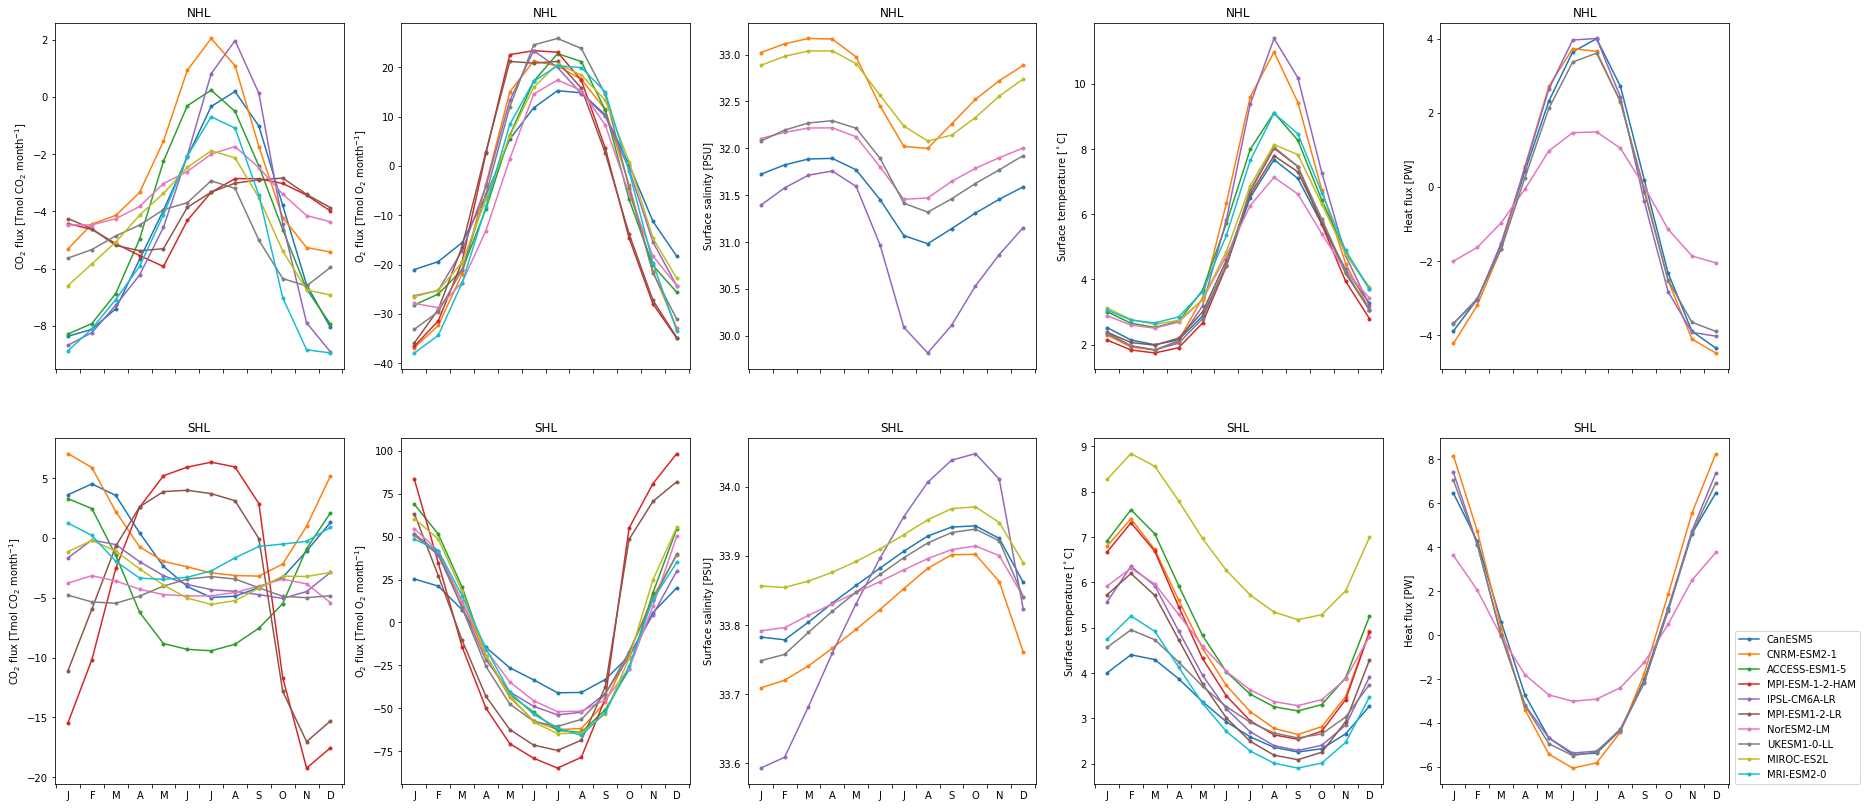

In [19]:
variable_ids = ['fgco2','fgo2','sos','tos','hfds']
#variable_ids = ['fgco2','fgo2','fgn2','fgo2_thermal','intpp'] 

#nrows = 2*np.ceil(len(variable_ids)/3).astype(int)
#ncols = np.ceil(len(variable_ids)/nrows).astype(int)
nrows = 2
ncols = len(variable_ids)


fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 7*nrows), facecolor='w', sharex=True) #, sharey=True)

for field, region, ax in zip(variable_ids*len(ds.region.values),np.repeat(ds.region.values,len(variable_ids)), axs.ravel()):
    for source_id in ds.source_id.values:
        ax.plot(
            ds.month-0.5, 
            ds[field].sel(source_id=source_id, region=region), 
            marker='.', 
            linestyle='-',
            label=source_id,
        )

    ax.set_xticks(np.arange(13))    
    ax.set_ylabel(f"{ds[field].attrs['long_name']} [{ds[field].attrs['units']}]")
    ax.set_title(region);
    ax.set_xticklabels([])
    ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
ax.legend(loc=(1.02, 0));

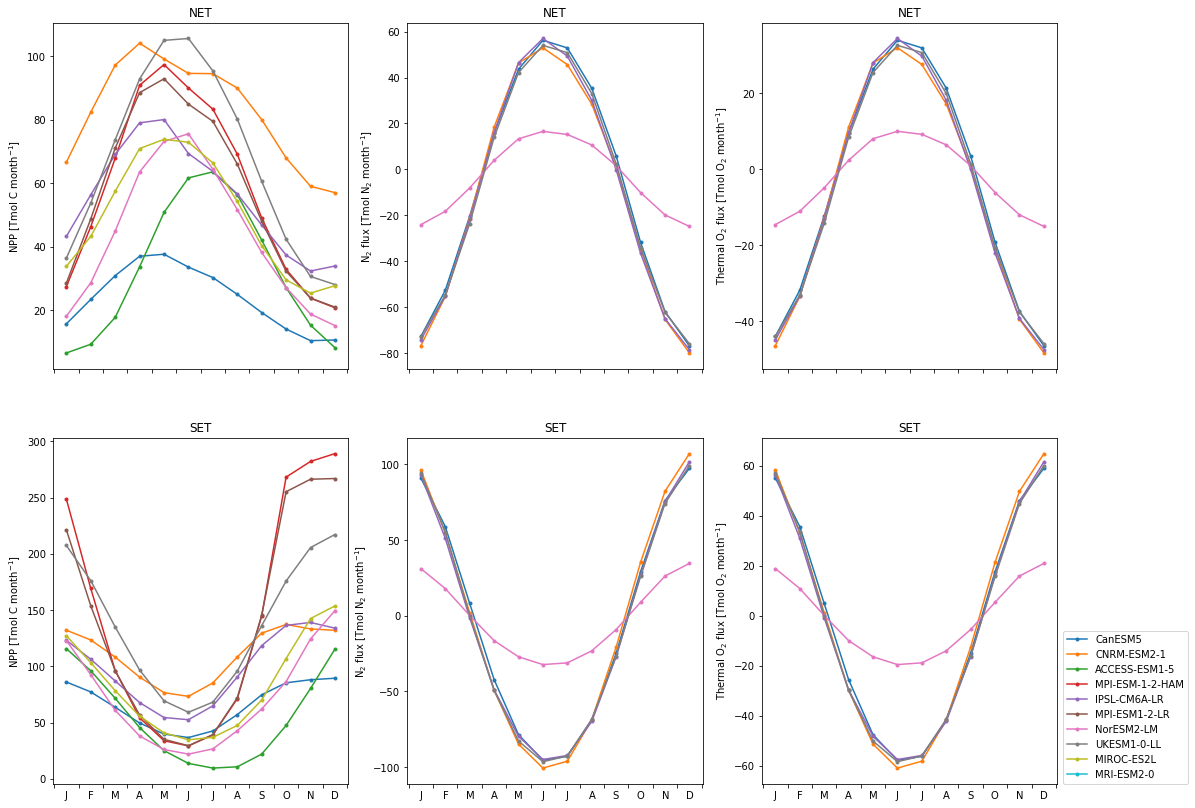

In [15]:
variable_ids = [ 'intpp', 'fgn2', 'fgo2_thermal']

nrows = 2
ncols = len(variable_ids)

fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 7*nrows), facecolor='w', sharex=True) #, sharey=True)

for field, region, ax in zip(variable_ids*len(ds.region.values),np.repeat(ds.region.values,len(variable_ids)), axs.ravel()):
    for source_id in ds.source_id.values:
        ax.plot(
            ds.month-0.5, 
            ds[field].sel(source_id=source_id, region=region), 
            marker='.', 
            linestyle='-',
            label=source_id,
        )

    ax.set_xticks(np.arange(13))    
    ax.set_ylabel(f"{ds[field].attrs['long_name']} [{ds[field].attrs['units']}]")
    ax.set_title(region);
    ax.set_xticklabels([])
    ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
ax.legend(loc=(1.02, 0));